In [1]:
!pip install nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
CONFUSION-MATRIX
[[124   0   0]
 [  0  38   0]
 [  0   0  38]]
CLASSIFICATION-REPORT
              precision    recall  f1-score   support

         MID       1.00      1.00      1.00       124
    NEGATIVE       1.00      1.00      1.00        38
    POSITIVE       1.00      1.00      1.00        38

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



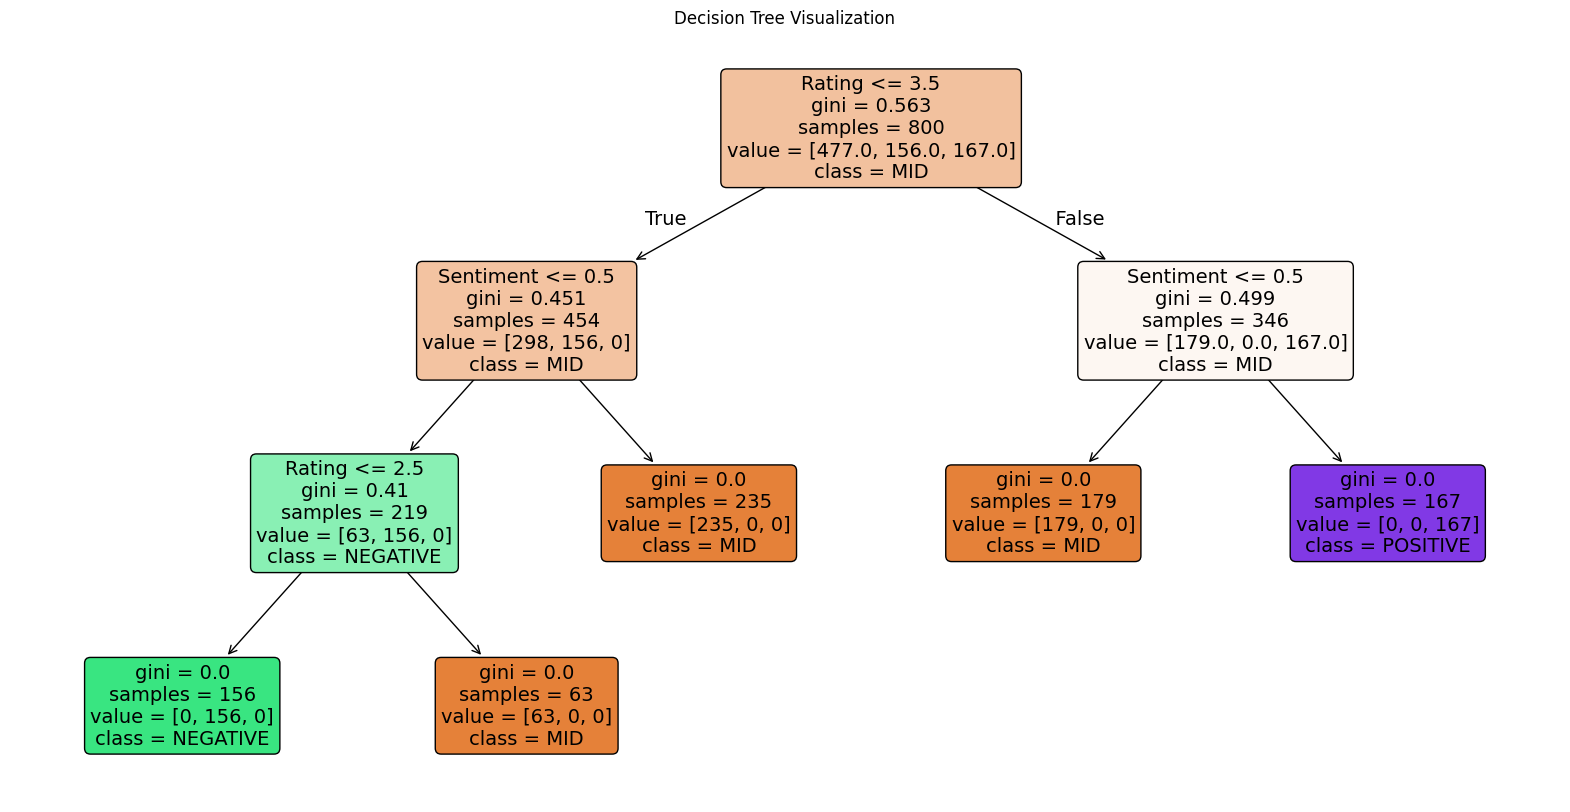

Model Evaluation Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [6]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,classification_report
from nltk.stem import PorterStemmer
# Download NLTK resources
nltk.download('stopwords')


# Initialize the stemmer
stemmer = PorterStemmer()

# Apply stemming to each word in the "Review_Text" column

# Load the dataset
df = pd.read_csv("healthcare_reviews.csv")  # Path to uploaded file
df = df.fillna("normal")
def stem_text(text):
    # Tokenize the text, stem each word, and join back into a single string
    return " ".join([stemmer.stem(word) for word in text.split()])

# Apply stemming to the Review_Text column
df['Review_Text'] = df['Review_Text'].apply(stem_text)
# Define stopwords
stop_words = set(stopwords.words('english'))

# Convert stop_words to a list
stop_words = list(stop_words)  # Convert the set to a list

# Feature Extraction: TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words=stop_words, lowercase=True)
X_tfidf = tfidf.fit_transform(df["Review_Text"])


# Convert TF-IDF to DataFrame for easier handling
X = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Encode sentiment labels
data1 = ['POSITIVE', 'NEGATIVE']
label_encoder = LabelEncoder()
encoded_data = label_encoder.fit_transform(data1)

# Mock sentiment analysis (replace this with your actual sentiment analysis function)
def senti_analysis(review):
    # Mock response assuming alternating positive/negative for simplicity
    import random
    return [{"label": random.choice(["POSITIVE", "NEGATIVE"])}]

Reviewnumber = []
for k in df["Review_Text"]:
    k = senti_analysis(k)
    k1 = k[0]
    k2 = k1['label']
    k3 = data1.index(k2)
    k4 = encoded_data[k3]
    Reviewnumber.append(k4)
df['Reviewnumber'] = Reviewnumber

# Create target variable
type = []
for i in range(len(df["Rating"])):
    if df["Rating"][i] > 3 and df["Reviewnumber"][i] == 1:
        type.append('POSITIVE')
    elif df["Rating"][i] < 3 and df["Reviewnumber"][i] == 0:
        type.append('NEGATIVE')
    else:
        type.append('MID')
df['Type'] = type

y = df['Type']  # Target variable
X['Rating'] = df['Rating']
X['Sentiment'] = df['Reviewnumber']

# Ensure the target variable remains the same
y = df['Type']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = DecisionTreeClassifier(random_state=42)

# Hyperparameter tuning setup
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']  # Removed 'auto'
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and model
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model
y_pred = best_model.predict(X_test)
print("CONFUSION-MATRIX")
print(confusion_matrix(y_test, y_pred))
print("CLASSIFICATION-REPORT")
print(classification_report(y_test, y_pred))

# Plot the decision tree of the best model
plt.figure(figsize=(20,10))
plot_tree(best_model,
          feature_names=X.columns,
          class_names=best_model.classes_,
          filled=True,
          rounded=True,
          fontsize=14)
plt.title('Decision Tree Visualization')
plt.show()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use weighted for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Macro-Averaged ROC-AUC (Multi-Class): 0.58


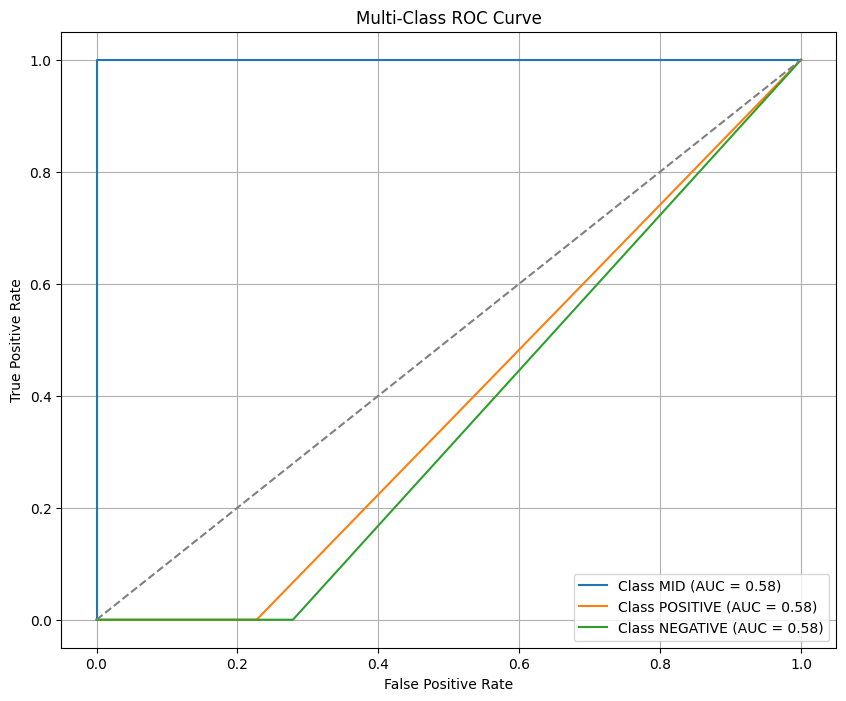

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Ensure y_test and y_pred are compatible
unique_classes = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=unique_classes)

# Predict probabilities for all classes
y_proba = best_model.predict_proba(X_test)

# Calculate ROC-AUC for each class using One-vs-Rest strategy
roc_auc = roc_auc_score(y_test_binarized, y_proba, average='macro', multi_class='ovr')

# Print the overall ROC-AUC
print(f"Macro-Averaged ROC-AUC (Multi-Class): {roc_auc:.2f}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(unique_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')

# Add diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize plot
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid()
plt.show()


In [7]:
# Function to classify a new review and rating
def classify_new_review(review_text, rating, tfidf, model, data1, label_encoder):
    """
    Classify a new review based on its text and rating.

    Parameters:
    - review_text: str, the text of the review
    - rating: int, the rating of the review
    - tfidf: TfidfVectorizer, the trained TF-IDF vectorizer
    - model: DecisionTreeClassifier, the trained model
    - data1: list, original sentiment labels (e.g., ['POSITIVE', 'NEGATIVE'])
    - label_encoder: LabelEncoder, the encoder for sentiment labels

    Returns:
    - classification: str, the predicted class (POSITIVE, NEGATIVE, MID)
    """
    # Preprocess the review text using TF-IDF
    review_tfidf = tfidf.transform([review_text])

    # Sentiment analysis mock (replace this with your actual sentiment analysis)
    senti_result = senti_analysis(review_text)  # Replace with actual function
    sentiment_label = senti_result[0]['label']  # Extract sentiment label

    # Convert sentiment label to encoded form
    sentiment_encoded = label_encoder.transform([sentiment_label])[0]

    # Combine the features for prediction (adding rating and sentiment info)
    review_features = pd.DataFrame(
        review_tfidf.toarray(),
        columns=tfidf.get_feature_names_out()
    )
    # Add Rating and Sentiment as additional features
    review_features['Rating'] = [rating]
    review_features['Sentiment'] = [sentiment_encoded]

    # Predict the class using the trained model
    prediction = model.predict(review_features)

    return prediction[0]  # Return the predicted class


# Example usage
new_review = "worst"
new_rating = 5

predicted_class = classify_new_review(
    review_text=new_review,
    rating=new_rating,
    tfidf=tfidf,
    model=best_model,
    data1=['POSITIVE', 'NEGATIVE'],
    label_encoder=label_encoder
)

print("The predicted class for the new review is:", predicted_class)


The predicted class for the new review is: MID
